In [8]:
import numpy as np

class Body:

    def __init__(self, mass, position, velocity):
        self.mass = mass # mass of body [kg]
        self.position = np.array(position) # position of body [m]
        self.velocity = np.array(velocity) # velocity of body [m/s]
        self.force = np.array([0, 0]) # force on body [N]

    def calculate_force(self, other_body):
        G = 1 # gravitational constant
        soft = 0.05 # softening parameter

        # displacement vector from self to other_body
        r = other_body.position - self.position 

        # force vector on self from other_body
        F = (G * other_body.mass * self.mass * r) / ((np.linalg.norm(r) + soft)**3)

        return F # return force vector on self from other_body

# initialize bodies with random masses, positions, and velocities over set range
# num_bodies [scalar], mass_range [low, high], position_range [low, high], velocity_range [low, high]
def initialize_bodies(num_bodies, mass_range, position_range, velocity_range):

    masses = np.random.uniform(mass_range[0], mass_range[1], num_bodies)
    positions = np.random.uniform(position_range[0], position_range[1], (num_bodies, 2))
    velocities = np.random.uniform(velocity_range[0], velocity_range[1], (num_bodies, 2))

    # returning list of bodies
    return [Body(masses[i], positions[i], velocities[i]) for i in range(num_bodies)]

In [10]:
class Node:

#Initializes Nodes. 
#Points should be a list of the indices of the bodies within the node
#Measure position of nodes from center of the node
#size should be an integer. will determine size of the nodes based upon a fraction of the total size: e.g. (n/2**size)
    def __init__(self, points, nodeposition, size):
        self.points = points
        self.nodeposition = nodeposition
        self.size = size
        self.quad1 = None
        self.quad2 = None
        self.quad3 = None
        self.quad4 = None

# calculates the center of mass of all bodies within the node
    def CoM(self, bodies):

        if len(self.points) != 0:
            # calculate center of mass of node
            CoM = sum(bodies[i].mass * bodies[i].position for i in self.points) / sum(bodies[i].mass for i in self.points)

            return CoM
        else:
            return
        
# passed variable "bodies" should be all of the bodies in the node's quadrant
# passed variable "nodelist" is the list of nodes within the quadtree, and is passed to the function for every recursion
# simsize is consistent, and is modified based on the size of the node
    def subdivide(self, bodies, nodelist, simsize):

# Detects boundaries for each quadrant and sorts the bodies accordingly
        quad1points = []
        quad2points = []
        quad3points = []
        quad4points = []

        for i in self.points:
            
            if  bodies[i].position[0] <= self.nodeposition[0]:
                if bodies[i].position[1] >= self.nodeposition[1]:
                    quad1points.append(i)
                else:
                    quad3points.append(i)
            else:
                if bodies[i].position[1] >= self.nodeposition[1]:
                    quad2points.append(i)
                else:
                    quad4points.append(i)
        
# Appends new child nodes to the nodelist
# Existing parent node is given the indices to the child node within the nodelist
        nodelist.append(Node(quad1points, [self.nodeposition[0]-(simsize/(2**(self.size+1))), self.nodeposition[1]+(simsize/(2**(self.size+1)))], self.size+1))
        self.quad1 = len(nodelist)-1
        nodelist.append(Node(quad2points, [self.nodeposition[0]+(simsize/(2**(self.size+1))), self.nodeposition[1]+(simsize/(2**(self.size+1)))], self.size+1))
        self.quad2 = len(nodelist)-1
        nodelist.append(Node(quad3points, [self.nodeposition[0]-(simsize/(2**(self.size+1))), self.nodeposition[1]-(simsize/(2**(self.size+1)))], self.size+1))
        self.quad3 = len(nodelist)-1
        nodelist.append(Node(quad4points, [self.nodeposition[0]+(simsize/(2**(self.size+1))), self.nodeposition[1]-(simsize/(2**(self.size+1)))], self.size+1))
        self.quad4 = len(nodelist)-1

# Recursive function that checks whether a quadrant has multiple bodies. If it does, runs subdivide. If not, ends that section of the recursion
# Passed "bodies" variable is all bodies within
    def checkQuad(self, bodies, nodelist, simsize):

# If this part ever breaks in the future, just make it so that len(self.points) == 1 or len(self.points) == 0
        if len(self.points) <= 1 :

            return
        
        if len(self.points) > 1:

            self.subdivide(bodies, nodelist, simsize)

# Calls itself recursively
            nodelist[self.quad1].checkQuad(bodies, nodelist, simsize)
            nodelist[self.quad2].checkQuad(bodies, nodelist, simsize)
            nodelist[self.quad3].checkQuad(bodies, nodelist, simsize)
            nodelist[self.quad4].checkQuad(bodies, nodelist, simsize)


class Quadtree:
    
# Takes bodies of simulation, and simulation size and generates a quadtree with a list of nodes
# Each node contains the nessecary information in a node, as well as the index numbers of it's children
# bodies is all bodies within the simulation in the bodies data structure
    def __init__(self, bodies, simsize):
        self.bodies = bodies
        self.simsize = simsize
        self.nodelist = [Node(list(range(len(bodies))), [0, 0], 1)]
        
        self.nodelist[0].checkQuad(self.bodies, self.nodelist, self.simsize)
   

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# initialize bodies with random masses, positions, and velocities over set range
# bodies[n] = Body(mass, position [x, y], velocity [vx, vy])
bodies = initialize_bodies(10, mass_range = [1, 10], position_range = [-32, 32], velocity_range = [-5, 5])
positions = [body.position for body in bodies]
# printing sample values
# print(bodies[0].mass)
# print(bodies[0].position)
# print(bodies[0].velocity)
# print(len(bodies))


QuadTest = Quadtree(bodies, 64)

# function below lists node data. You can use it for debugging
for i in range(len(QuadTest.nodelist)):
    print( 'points ' + str(QuadTest.nodelist[i].points) + ' nodeposition ' +str(QuadTest.nodelist[i].nodeposition) + ' size ' +str(QuadTest.nodelist[i].size) + ' Center of Mass ' + str(QuadTest.nodelist[i].CoM(bodies)))

points [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] nodeposition [0, 0] size 1 Center of Mass [15.10272474 -5.7603356 ]
points [5] nodeposition [-16.0, 16.0] size 2 Center of Mass [-27.45190447  12.56086487]
points [2, 7, 8] nodeposition [16.0, 16.0] size 2 Center of Mass [28.07281117 20.4133827 ]
points [0, 4] nodeposition [-16.0, -16.0] size 2 Center of Mass [ -4.54311514 -30.00785651]
points [1, 3, 6, 9] nodeposition [16.0, -16.0] size 2 Center of Mass [ 17.94014836 -11.14649858]
points [2] nodeposition [8.0, 24.0] size 3 Center of Mass [14.65571094 19.88645772]
points [7, 8] nodeposition [24.0, 24.0] size 3 Center of Mass [29.19849282 20.45759119]
points [] nodeposition [8.0, 8.0] size 3 Center of Mass None
points [] nodeposition [24.0, 8.0] size 3 Center of Mass None
points [] nodeposition [20.0, 28.0] size 4 Center of Mass None
points [] nodeposition [28.0, 28.0] size 4 Center of Mass None
points [] nodeposition [20.0, 20.0] size 4 Center of Mass None
points [7, 8] nodeposition [28.0, 20.0] si

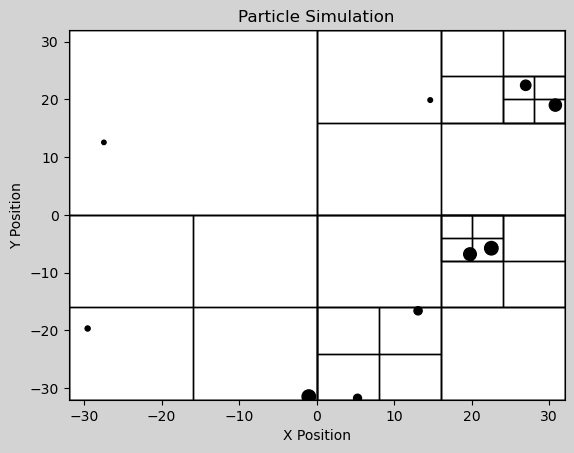

In [12]:
# Example animation using matplotlib

# %matplotlib widget

# Time step for position updates
dt = 0.1

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(-32, 32) # X-axis limits
ax.set_ylim(-32, 32) # Y-axis limits
ax.set_title("Particle Simulation", color="black")  # Title
ax.set_xlabel("X Position", color="black")  # X-axis label
ax.set_ylabel("Y Position", color="black")  # Y-axis label
ax.tick_params(axis='x', colors="black")  # X-axis ticks
ax.tick_params(axis='y', colors="black")  # Y-axis ticks
ax.set_facecolor("white")  # Set background color
fig.patch.set_facecolor("lightgray")  # Outside the plot

# Create scatter plot with initial positions
scat = ax.scatter(
    [body.position[0] for body in bodies], # Initial x-coordinate of bodies
    [body.position[1] for body in bodies], # Initial y-coordinate of bodies
    s=[body.mass * 10 for body in bodies], # Size of bodies proportional to mass
    c="black",  # Color of bodies
)

pos1 = []
pos2 = []
for i in range(len(QuadTest.nodelist)):
    pos1.append(QuadTest.nodelist[i].nodeposition[0])
    pos2.append(QuadTest.nodelist[i].nodeposition[1])

#scat2 = ax.scatter(pos1, pos2, c='blue')

for i in range(len(QuadTest.nodelist)):
    formatcoords = [QuadTest.nodelist[i].nodeposition[0]-(64/2**(QuadTest.nodelist[i].size)), QuadTest.nodelist[i].nodeposition[1]-(64/2**(QuadTest.nodelist[i].size))]

# If you want to do graphical representations of the quadtree, you need to subtract 1 from the size. It's just kind of a quirk of how i coded it. 
    Rect = patches.Rectangle(formatcoords, (64/2**(QuadTest.nodelist[i].size-1)), (64/2**(QuadTest.nodelist[i].size-1)), ec = 'black', fill =False)
    plt.gca().add_patch(Rect)

# Update function for animation
# def update_position(frame):

#     updated_positions = [] # Initialize as a list

#     for body in bodies:
#         body.position += body.velocity * dt  # Update positions
#         updated_positions.append(body.position)  # Collect new positions
#     scat.set_offsets(updated_positions)  # Update scatter plot
    
#     return scat

# # Create the animation
# ani = animation.FuncAnimation(
#     fig=fig,
#     func=update_position,
#     frames=range(50),  # Number of frames
#     interval=50,  # Time between frames in milliseconds
#     repeat=False,  # Stop after the last frame
# )

# # Show the plot
plt.show()


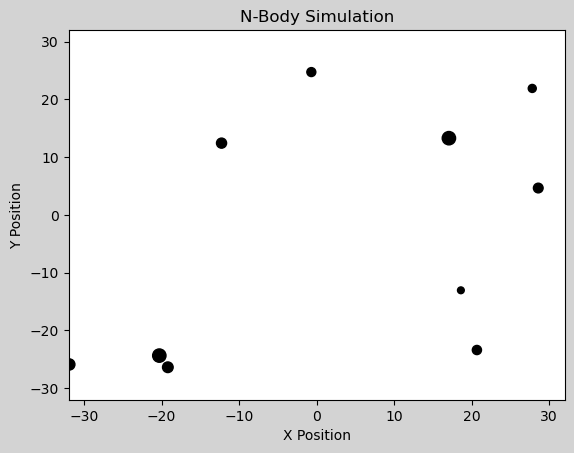

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Constants
G = 1  # Gravitational constant (in arbitrary units)

# Define the Body class for the N-body simulation
class Body:
    def __init__(self, mass, position, velocity):
        self.mass = mass  # Mass of the body [kg]
        self.position = np.array(position)  # Position of the body [m]
        self.velocity = np.array(velocity)  # Velocity of the body [m/s]
        self.force = np.array([0, 0])  # Force acting on the body [N]

    def update(self, dt):
        # Update the velocity and position using Newton's second law: F = ma => a = F/m
        acceleration = self.force / self.mass
        self.velocity += acceleration * dt
        self.position += self.velocity * dt

    def reset_force(self):
        self.force = np.array([0, 0])

# Gravitational force calculation
def calculate_gravitational_force(body1, body2):
    r = body2.position - body1.position
    distance = np.linalg.norm(r)
    
    # Softening parameter to avoid singularities when bodies are too close
    softening = 0.1  # This can be adjusted for better stability
    distance = np.sqrt(distance**2 + softening**2)  # Softened distance
    
    force_magnitude = G * body1.mass * body2.mass / (distance**2)
    force_direction = r / distance  # Unit vector pointing from body1 to body2
    force = force_magnitude * force_direction
    return force

# Initialize bodies with random masses, positions, and velocities
def initialize_bodies(num_bodies, mass_range, position_range, velocity_range):
    masses = np.random.uniform(mass_range[0], mass_range[1], num_bodies)
    positions = np.random.uniform(position_range[0], position_range[1], (num_bodies, 2))
    velocities = np.random.uniform(velocity_range[0], velocity_range[1], (num_bodies, 2))
    return [Body(masses[i], positions[i], velocities[i]) for i in range(num_bodies)]

# Initialize simulation parameters
num_bodies = 10
mass_range = [1, 10]
position_range = [-32, 32]
velocity_range = [-5, 5]
bodies = initialize_bodies(num_bodies, mass_range, position_range, velocity_range)

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(-32, 32)  # X-axis limits
ax.set_ylim(-32, 32)  # Y-axis limits
ax.set_title("N-Body Simulation", color="black")  # Title
ax.set_xlabel("X Position", color="black")  # X-axis label
ax.set_ylabel("Y Position", color="black")  # Y-axis label
ax.tick_params(axis='x', colors="black")  # X-axis ticks
ax.tick_params(axis='y', colors="black")  # Y-axis ticks
ax.set_facecolor("white")  # Set background color
fig.patch.set_facecolor("lightgray")  # Outside the plot

# Create scatter plot with initial positions
scat = ax.scatter(
    [body.position[0] for body in bodies],  # Initial x-coordinate of bodies
    [body.position[1] for body in bodies],  # Initial y-coordinate of bodies
    s=[body.mass * 10 for body in bodies],  # Size of bodies proportional to mass
    c="black",  # Color of bodies
)

# Function to update the simulation for each frame
def update_position(frame):
    # Reset forces before each frame
    for body in bodies:
        body.reset_force()

    # Calculate forces between each pair of bodies (gravity)
    for i, body1 in enumerate(bodies):
        for j, body2 in enumerate(bodies):
            if i != j:  # Don't calculate force on itself
                force = calculate_gravitational_force(body1, body2)
                body1.force += force
                body2.force -= force  # Action and reaction forces

    # Update positions and velocities for each body
    for body in bodies:
        body.update(dt=0.1)  # Use a larger dt to see noticeable movement

    # Update scatter plot with new positions
    scat.set_offsets([body.position for body in bodies])
    return scat

# Create the animation
ani = animation.FuncAnimation(
    fig=fig,
    func=update_position,
    frames=range(200),  # Number of frames
    interval=50,  # Time between frames in milliseconds
    repeat=False,  # Stop after the last frame
)

# Show the plot
plt.show()


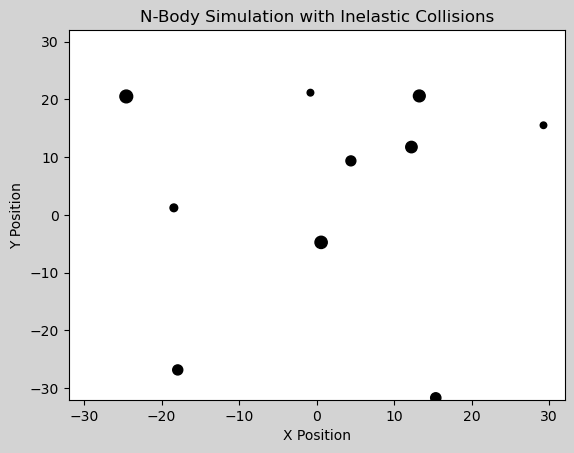

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Constants
G = 1  # Gravitational constant (in arbitrary units)

# Define the Body class for the N-body simulation
class Body:
    def __init__(self, mass, position, velocity, radius):
        self.mass = mass  # Mass of the body [kg]
        self.position = np.array(position)  # Position of the body [m]
        self.velocity = np.array(velocity)  # Velocity of the body [m/s]
        self.force = np.array([0, 0])  # Force acting on the body [N]
        self.radius = radius  # Radius of the body [m]

    def update(self, dt):
        """Update position and velocity based on forces."""
        acceleration = self.force / self.mass  # F = ma => a = F/m
        self.velocity += acceleration * dt  # Update velocity
        self.position += self.velocity * dt  # Update position

    def reset_force(self):
        """Reset the force applied to the body."""
        self.force = np.array([0, 0])

    def collide(self, other):
        """Handle inelastic collision with another body."""
        # Calculate the velocity after collision based on momentum conservation
        total_mass = self.mass + other.mass
        new_velocity = (self.mass * self.velocity + other.mass * other.velocity) / total_mass
        
        # Both bodies now move with the same velocity (perfectly inelastic)
        self.velocity = new_velocity
        other.velocity = new_velocity

        # Combine masses and radii for the new merged body
        self.mass = total_mass
        self.radius = (self.radius + other.radius)  # Simply add radii for simplicity

        # Position is set to the average position of the two bodies
        self.position = (self.position * self.mass + other.position * other.mass) / total_mass

        # Mark the other body for removal (it is now merged with the current body)
        other.mass = 0  # Effectively "removes" the other body

# Gravitational force calculation
def calculate_gravitational_force(body1, body2):
    r = body2.position - body1.position
    distance = np.linalg.norm(r)
    
    # Softening parameter to avoid singularities when bodies are too close
    softening = 0.1  # This can be adjusted for better stability
    distance = np.sqrt(distance**2 + softening**2)  # Softened distance
    
    force_magnitude = G * body1.mass * body2.mass / (distance**2)
    force_direction = r / distance  # Unit vector pointing from body1 to body2
    force = force_magnitude * force_direction
    return force

# Initialize bodies with random masses, positions, and velocities
def initialize_bodies(num_bodies, mass_range, position_range, velocity_range):
    masses = np.random.uniform(mass_range[0], mass_range[1], num_bodies)
    positions = np.random.uniform(position_range[0], position_range[1], (num_bodies, 2))
    velocities = np.random.uniform(velocity_range[0], velocity_range[1], (num_bodies, 2))
    radii = np.random.uniform(1, 3, num_bodies)  # Assign random radii
    return [Body(masses[i], positions[i], velocities[i], radii[i]) for i in range(num_bodies)]

# Initialize simulation parameters
num_bodies = 10
mass_range = [1, 10]
position_range = [-32, 32]
velocity_range = [-5, 5]
bodies = initialize_bodies(num_bodies, mass_range, position_range, velocity_range)

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(-32, 32)  # X-axis limits
ax.set_ylim(-32, 32)  # Y-axis limits
ax.set_title("N-Body Simulation with Inelastic Collisions", color="black")  # Title
ax.set_xlabel("X Position", color="black")  # X-axis label
ax.set_ylabel("Y Position", color="black")  # Y-axis label
ax.tick_params(axis='x', colors="black")  # X-axis ticks
ax.tick_params(axis='y', colors="black")  # Y-axis ticks
ax.set_facecolor("white")  # Set background color
fig.patch.set_facecolor("lightgray")  # Outside the plot

# Create scatter plot with initial positions
scat = ax.scatter(
    [body.position[0] for body in bodies],  # Initial x-coordinate of bodies
    [body.position[1] for body in bodies],  # Initial y-coordinate of bodies
    s=[body.mass * 10 for body in bodies],  # Size of bodies proportional to mass
    c="black",  # Color of bodies
)

# Function to update the simulation for each frame
def update_position(frame):
    # Reset forces before each frame
    for body in bodies:
        body.reset_force()

    # Calculate forces between each pair of bodies (gravity)
    for i, body1 in enumerate(bodies):
        for j, body2 in enumerate(bodies):
            if i != j:  # Don't calculate force on itself
                force = calculate_gravitational_force(body1, body2)
                body1.force += force
                body2.force -= force  # Action and reaction forces

    # Check for collisions between bodies
    for i, body1 in enumerate(bodies):
        for j, body2 in enumerate(bodies):
            if i < j:  # Avoid checking the same pair twice
                distance = np.linalg.norm(body2.position - body1.position)
                combined_radius = body1.radius + body2.radius
                if distance < combined_radius:  # If the bodies collide
                    body1.collide(body2)

    # Update positions and velocities for each body
    for body in bodies:
        if body.mass > 0:  # Ensure the body is still active (not merged)
            body.update(dt=0.1)  # Use a larger dt to see noticeable movement

    # Update scatter plot with new positions
    scat.set_offsets([body.position for body in bodies if body.mass > 0])  # Only active bodies
    scat.set_sizes([body.mass * 10 for body in bodies if body.mass > 0])  # Update sizes
    return scat

# Create the animation
ani = animation.FuncAnimation(
    fig=fig,
    func=update_position,
    frames=range(200),  # Number of frames
    interval=50,  # Time between frames in milliseconds
    repeat=False,  # Stop after the last frame
)

# Show the plot
plt.show()
